In [36]:
import pandas as pd
import math
import copy
from graphviz import Graph
import matplotlib.pyplot as plt
import numpy as np
import pydot
from scipy.interpolate import lagrange
from numpy.polynomial.polynomial import Polynomial
from sklearn.tree import DecisionTreeClassifier

### Glossary
- c: threshold
- features: x1 and x2 (dimentions of the data)

### Import data

In [2]:
D1 =  pd.read_csv(r'Homework 2 data/D1.txt', sep=' ', names=["x1","x2","y"])
D2 =  pd.read_csv(r'Homework 2 data/D2.txt', sep=' ', names=["x1","x2","y"])
D3leaves =  pd.read_csv(r'Homework 2 data/D3leaves.txt', sep=' ', names=["x1","x2","y"])
Dbig =  pd.read_csv(r'Homework 2 data/Dbig.txt', sep=' ', names=["x1","x2","y"])
Druns =  pd.read_csv(r'Homework 2 data/Druns.txt', sep=' ', names=["x1","x2","y"])

### Auxiliary Functions

In [3]:
def CalculateEntropy(D):
    if len(D) == 0:
        return 0
    else:
        count_label_0 = len(D[D["y"]==0])
        count_label_1 = len(D[D["y"]==1])
        if count_label_0 == 0 or count_label_1 == 0:
            return 0
        else:
            count_total = count_label_0 + count_label_1
            P0 = count_label_0/count_total
            P1 = count_label_1/count_total
            entropy = - (P0*math.log2(P0) + P1*math.log2(P1))
            return entropy

In [4]:
def FindBestSplit(D):
    #print("NODE")
    
    split = (None, None, 0, None, None) # (feature, c , gain_ratio, group1, group2)
    # entropy of parent    
    entropy_parent = CalculateEntropy(D)
    #print(entropy_parent)
    # entropy of child (test all possibilities)
    for col in ["x1","x2"]:
        sorted_feature = D.sort_values(by=col)
        for index, row in sorted_feature.iterrows():
            c = row[col]
            group_1 = sorted_feature[sorted_feature[col]<c]
            entropy_group_1 = CalculateEntropy(group_1)
            group_2 = sorted_feature[sorted_feature[col]>=c]
            entropy_group_2 = CalculateEntropy(group_2)
            entropy_child = (len(group_1)*entropy_group_1 + len(group_2)*entropy_group_2)/len(D)

            
            #entropy split
            count_label_0 = len(group_1)
            count_label_1 = len(group_2)
            if count_label_0 == 0 or count_label_1 == 0:
                entropy_split = 0
            else:
                count_total = count_label_0 + count_label_1
                P0 = count_label_0/count_total
                P1 = count_label_1/count_total
                entropy_split = - (P0*math.log2(P0) + P1*math.log2(P1))
            
        
            info_gain = entropy_parent - entropy_child
            if entropy_split == 0:
                #print(col,c,list(group_1[col]),list(group_2[col]),len(group_1),len(group_2),entropy_group_1,entropy_group_2,entropy_child,entropy_parent,entropy_split,info_gain,0)
                continue
            else:
                gain_ratio = info_gain/entropy_split
                #print("c",c,info_gain)
                if gain_ratio > split[2]:
                    split = (col,c,gain_ratio, group_1, group_2)
                    #print("IN",split)
            #print(col,c,list(group_1[col]),list(group_2[col]),len(group_1),len(group_2),entropy_group_1,entropy_group_2,entropy_child,entropy_parent,entropy_split,info_gain,gain_ratio)
    return split


In [5]:
def StoppingCriteria(D,S):
    feature, c, gain_ratio, group_1, group_2 = S
    if len(D) == 0:
        #print("len 0")
        return True
    elif gain_ratio == 0:
        #print("gain_ratio  0")
        return True
    else:
        return False

### Training Function

In [6]:
class TreeNode:
    def __init__(self, value):
        self.value = value
        self.feature = None
        self.cut = None
        self.left = None
        self.right = None
    def __str__(self):
        return str(self.value)


def Train(D):
    global training
    global n_nodes
    #print("New node")   
    n_nodes +=1
    value = 2
    node = TreeNode(value)
    S = FindBestSplit(D)
    feature, c, info_gain, group_1, group_2= S
    node.feature = feature
    node.cut = c
    if StoppingCriteria(D,S) == True:
        count_label_0 = len(D[D["y"]==0])
        count_label_1 = len(D[D["y"]==1])
        #print(count_label_0,count_label_1)
        if count_label_0 > count_label_1:
            value = 0
        else:
            value = 1
        node.value = value
    else:
        #print ("going left")
        node.left = Train(group_1)
        #print ("going right")
        node.right = Train(group_2)
        #print("end")
    return node
    

### Visualization Functions

In [8]:
def CreateGraph(tree):  
    global g
    if tree.feature is None:
        #g.node("Leaf", label=f"Feature: None\nCut: None")
        node_label = f"Leaf\nLabel: {round(tree.value, 2)}"
        g.node("Leaf", label=node_label, color="green")
    else:
        node_label = f"Feature: {tree.feature}\nCut: {round(tree.cut, 2)}"
        g.node(tree.feature + "-" + str(round(tree.cut, 2)), label=node_label, color="blue")
        
        if tree.value != 2:
            g.edge(tree.feature + "-" + str(round(tree.cut, 2)), str(tree.value), label="Leaf", color="red")
        else:
            if tree.left.value == 2:
                g.edge(tree.feature + "-" + str(round(tree.cut, 2)), tree.left.feature + "-" + str(round(tree.left.cut, 2)), label=f"< {round(tree.cut, 2)}")
            else:
                node_label = f"Leaf\nLabel: {round(tree.left.value, 2)}"
                g.node(str(tree.feature) + "-" + str(tree.cut) + "-" + str(tree.left.value), label=node_label, color="green")
                g.edge(tree.feature + "-" + str(round(tree.cut, 2)), str(tree.feature) + "-" + str(tree.cut) + "-" + str(tree.left.value), label=f"< {round(tree.cut, 2)}")
                
            if tree.right.value == 2:
                g.edge(tree.feature + "-" + str(round(tree.cut, 2)), tree.right.feature + "-" + str(round(tree.right.cut, 2)), label=f">= {round(tree.cut, 2)}")
            else:
                node_label = f"Leaf\nLabel: {round(tree.right.value, 2)}"
                g.node(str(tree.feature) + "-" + str(tree.cut) + "-" + str(tree.right.value), label=node_label, color="green")
                g.edge(tree.feature + "-" + str(round(tree.cut, 2)), str(tree.feature) + "-" + str(tree.cut) + "-" + str(tree.right.value), label=f">= {round(tree.cut, 2)}")
    
        if tree.left.value == 2:
            CreateGraph(tree.left)
        if tree.right.value == 2:
            CreateGraph(tree.right)

In [9]:
# hypotesis space
def CreateSpace(tree,df_test,save_path="Test.png"):
    import numpy as np
    import pandas as pd
    
    # Define the number of points you want to generate
    num_points = 1000000
    
    # Generate random x1 and x2 values within the specified range
    x1 = np.random.uniform(min(df_test["x1"]), max(df_test["x1"]), num_points)
    x2 = np.random.uniform(min(df_test["x2"]), max(df_test["x2"]), num_points)
    
    # Create a DataFrame
    df = pd.DataFrame({'x1': x1, 'x2': x2})
    space = Test(df,tree)
    
    df_y0 = space[space['y'] == 0]
    df_y1 = space[space['y'] == 1]
    
    fig = plt.figure(figsize=(9, 9)) 
    
    # Create the scatter plot
    plt.scatter(df_y0['x1'], df_y0['x2'], c='skyblue', label='y=0', s=1)
    plt.scatter(df_y1['x1'], df_y1['x2'], c='lightsalmon', label='y=1', s=1)

    # Test data
    df_y0 = df_test[df_test['y'] == 0]
    df_y1 = df_test[df_test['y'] == 1]
    
    # Create the scatter plot
    plt.scatter(df_y0['x1'], df_y0['x2'], c='blue', label='y=0', s=10)
    plt.scatter(df_y1['x1'], df_y1['x2'], c='red', label='y=1', s=10)
    
    # Add labels and legend
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('Hypotesis Space')

    plt.savefig(save_path)
    
    # Show the plot
    plt.show()

### Testing Function

In [10]:
def Test(D,tree):
    for index, row in D.iterrows():
        label = 2
        tt = copy.copy(tree)
        while True:
            label = tt.value
            if label != 2:
                break
            feature = tt.feature
            cut = tt.cut
            if row[feature]<cut:
                tt = tt.left
            else:
                tt = tt.right
        D.loc[index,"y"] = label
        #print(row["x1"],row["x2"], label)
    return D

### Running

### 2.1

In that case, the entropy of the parent node ($H(\text{parent})$) is equal to zero. Because all child nodes derived from the parent node will also contain items with the same class label, their entropies ($H(\text{child})$) will also be zero. This will lead to an InfoGain of zero for all possible combinations of child nodes (splits), which is one of our stopping criteria.

### 2.2

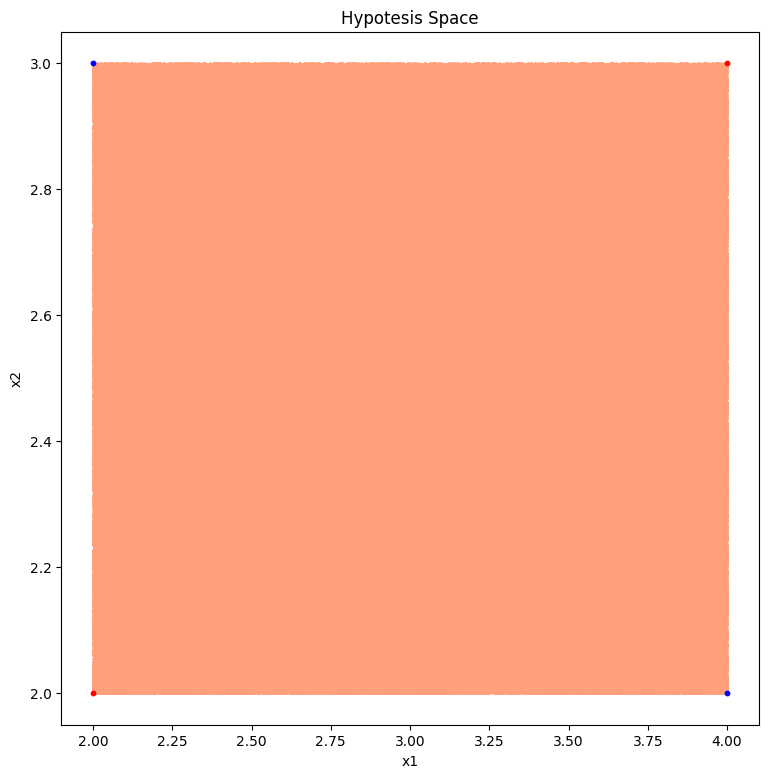

In [11]:
# create dataframe
data = {'x1': [4, 2, 4, 2], 'x2': [2, 3, 3, 2], 'y': [0, 0, 1, 1]}
df = pd.DataFrame(data)
training = df
training_2 = copy.copy(training)
n_nodes = 0
tree = Train(training)
g = Graph()
CreateGraph(tree)
g.render(filename='2_2a',view = False, format='png')
df_test = Test(training,tree)
CreateSpace(tree,training_2,"2_2b.png")

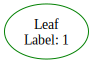

In [12]:
g

### 2.3

In [13]:
def FindBestSplit_2_3(D):
    split = (None, None, 0, None, None) # (feature, c , gain_ratio, group1, group2)
    # entropy of parent    
    entropy_parent = CalculateEntropy(D)
    #print(entropy_parent)
    # entropy of child (test all possibilities)
    for col in ["x1","x2"]:
        sorted_feature = D.sort_values(by=col)
        for index, row in sorted_feature.iterrows():
            c = row[col]
            group_1 = sorted_feature[sorted_feature[col]<c]
            entropy_group_1 = CalculateEntropy(group_1)
            group_2 = sorted_feature[sorted_feature[col]>=c]
            entropy_group_2 = CalculateEntropy(group_2)
            entropy_child = (len(group_1)*entropy_group_1 + len(group_2)*entropy_group_2)/len(D)

            
            #entropy split
            count_label_0 = len(group_1)
            count_label_1 = len(group_2)
            if count_label_0 == 0 or count_label_1 == 0:
                entropy_split = 0
            else:
                count_total = count_label_0 + count_label_1
                P0 = count_label_0/count_total
                P1 = count_label_1/count_total
                entropy_split = - (P0*math.log2(P0) + P1*math.log2(P1))
            
        
            info_gain = entropy_parent - entropy_child
            if entropy_split == 0:
                print("feature:",col,"split:",c,"info gain",round(info_gain,5))
                continue
            else:
                gain_ratio = info_gain/entropy_split
                #print("c",c,info_gain)
                if gain_ratio > split[2]:
                    split = (col,c,gain_ratio, group_1, group_2)
                    #print("IN",split)
            print("feature:",col,"split:",c,"gain ratio",round(gain_ratio,5))
    #return split

training = Druns
FindBestSplit_2_3(training)


feature: x1 split: 0.0 info gain 0.0
feature: x1 split: 0.0 info gain 0.0
feature: x1 split: 0.0 info gain 0.0
feature: x1 split: 0.0 info gain 0.0
feature: x1 split: 0.0 info gain 0.0
feature: x1 split: 0.0 info gain 0.0
feature: x1 split: 0.0 info gain 0.0
feature: x1 split: 0.0 info gain 0.0
feature: x1 split: 0.0 info gain 0.0
feature: x1 split: 0.0 info gain 0.0
feature: x1 split: 0.1 gain ratio 0.10052
feature: x2 split: -2.0 info gain 0.0
feature: x2 split: -1.0 gain ratio 0.10052
feature: x2 split: 0.0 gain ratio 0.05595
feature: x2 split: 1.0 gain ratio 0.00578
feature: x2 split: 2.0 gain ratio 0.00114
feature: x2 split: 3.0 gain ratio 0.01641
feature: x2 split: 4.0 gain ratio 0.04975
feature: x2 split: 5.0 gain ratio 0.11124
feature: x2 split: 6.0 gain ratio 0.2361
feature: x2 split: 7.0 gain ratio 0.05595
feature: x2 split: 8.0 gain ratio 0.43016


### 2.4 

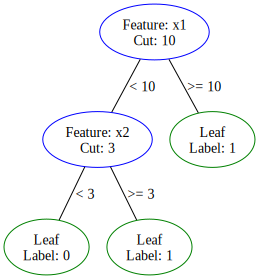

In [14]:
training = D3leaves
n_nodes = 0
tree = Train(training)
g = Graph()
CreateGraph(tree)
g.render(filename='2_4',view = False, format='png')
g
#df_test = Test(training,tree)
#CreateSpace(tree,df_test)

Logical rules:  (x1>=10) OR ((x1<10) AND (x2>=3))

### 2.5 

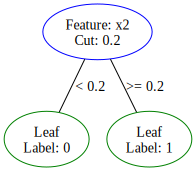

In [15]:
training = D1
n_nodes = 0
tree = Train(training)
g = Graph()
CreateGraph(tree)
g.render(filename='2_5a',view = False, format='png')
g

The tree for this example is fairly simple. When x2 <0.2 the class is 0 and 1 otherwise

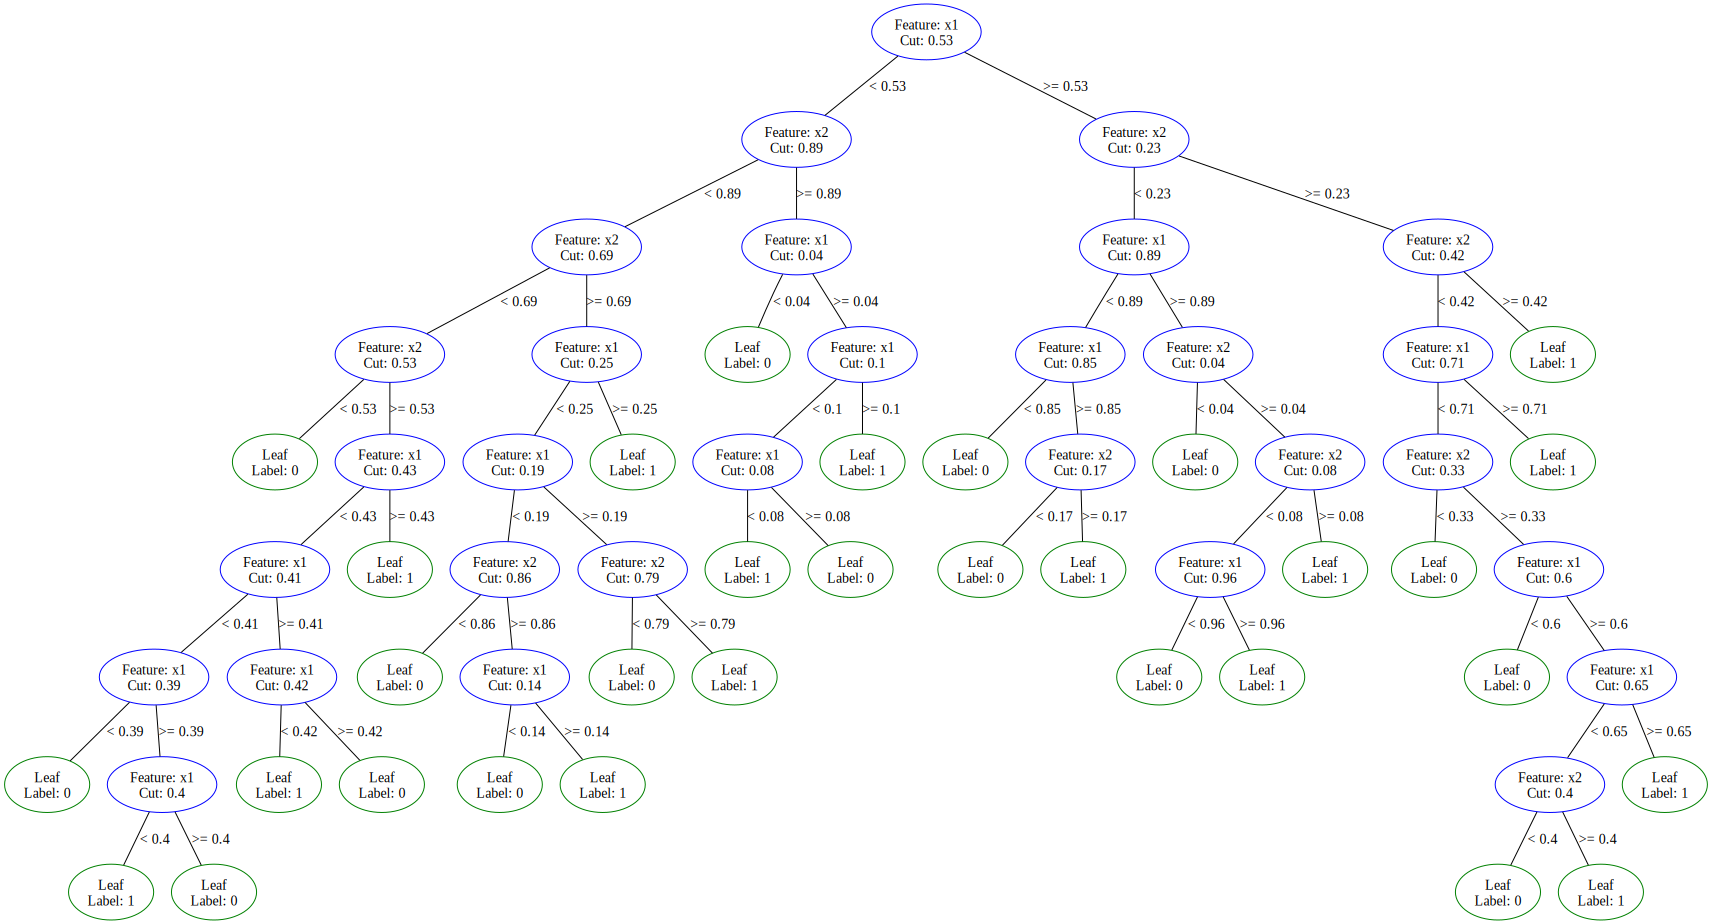

In [16]:
training = D2
n_nodes = 0
tree = Train(training)
g = Graph()
CreateGraph(tree)
g.render(filename='2_5b',view = False, format='png')
g

The tree in this case is complex. There is hard to observe any logical trend in the data without further visualization methods

### 2.6 

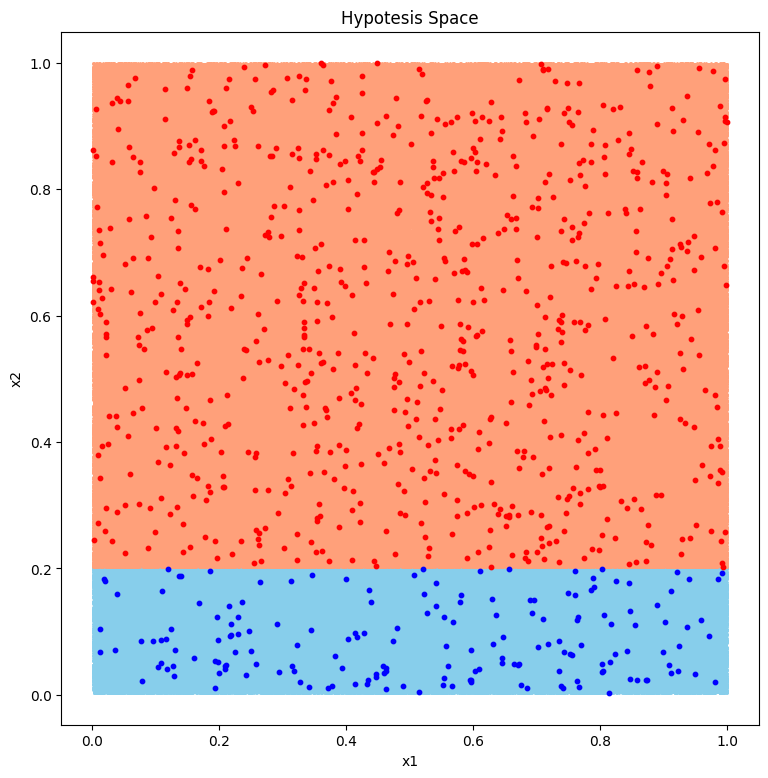

In [17]:
training = D1
n_nodes = 0
tree = Train(training)
g = Graph()
CreateGraph(tree)
df_test = Test(training,tree)
CreateSpace(tree,df_test,"2_6a.png")

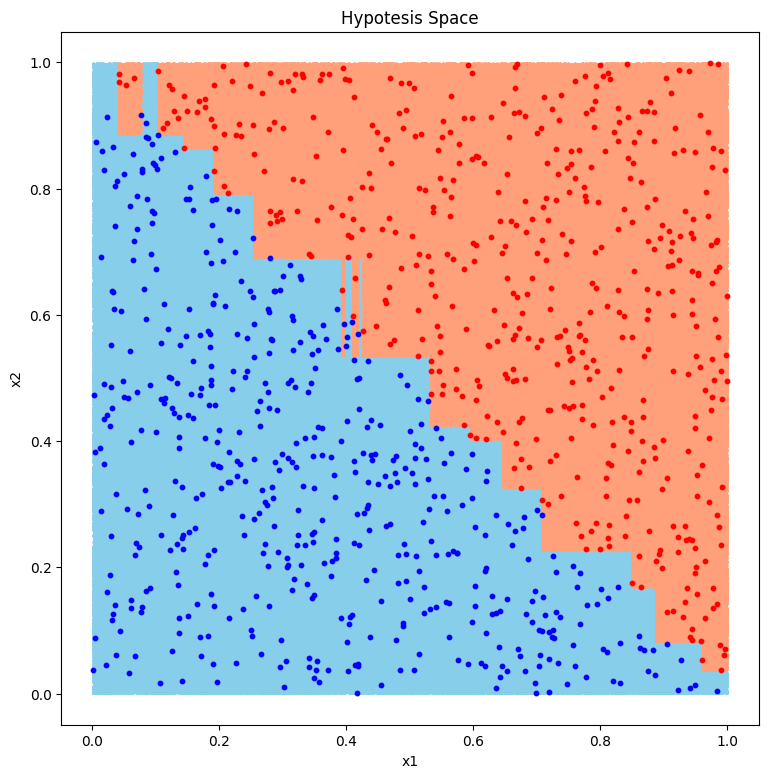

In [18]:
training = D2
n_nodes = 0
tree = Train(training)
g = Graph()
CreateGraph(tree)
df_test = Test(training,tree)
CreateSpace(tree,df_test,"2_6b.png")

The trees of D1 and D2 have different sizes because the logic behind the labeling does not heve the same complexity, as can be seen by the hypotesis spaces.

### 2.7

In [32]:
data = np.loadtxt('Homework 2 data/Dbig.txt')

# Generate a random permutation
permutation = np.random.permutation(len(data))

# Split the data into a candidate training set and a test set
candidate_training_set = data[permutation[:8192]]
test_set = data[permutation[8192:]]
D32 = candidate_training_set[:32]
D128 = candidate_training_set[:128]
D512 = candidate_training_set[:512]
D2048 = candidate_training_set[:2048]
D8192 = candidate_training_set

column_names = ["x1", "x2", "y"]
# Create dataframes for each dataset
df_test_set = pd.DataFrame(data=test_set, columns=column_names) 
df_actual = copy.copy(df_test_set)
df32 = pd.DataFrame(data=D32, columns=column_names)
df128 = pd.DataFrame(data=D128, columns=column_names)
df512 = pd.DataFrame(data=D512, columns=column_names)
df2048 = pd.DataFrame(data=D2048, columns=column_names)
df8192 = pd.DataFrame(data=D8192, columns=column_names)

training_data = {"32":df32,"128":df128,"512":df512,"2048":df2048,"8192":df8192}

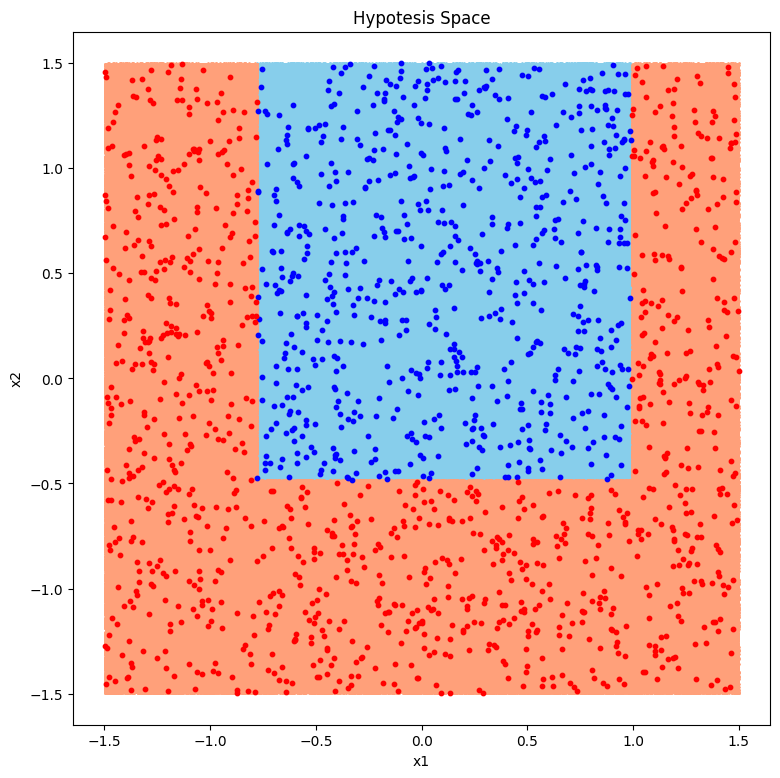

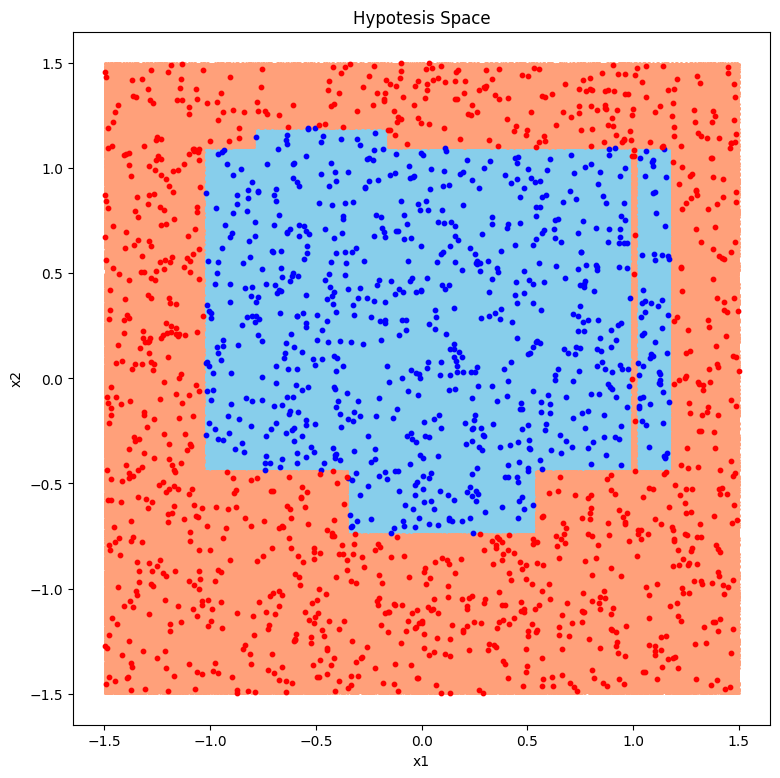

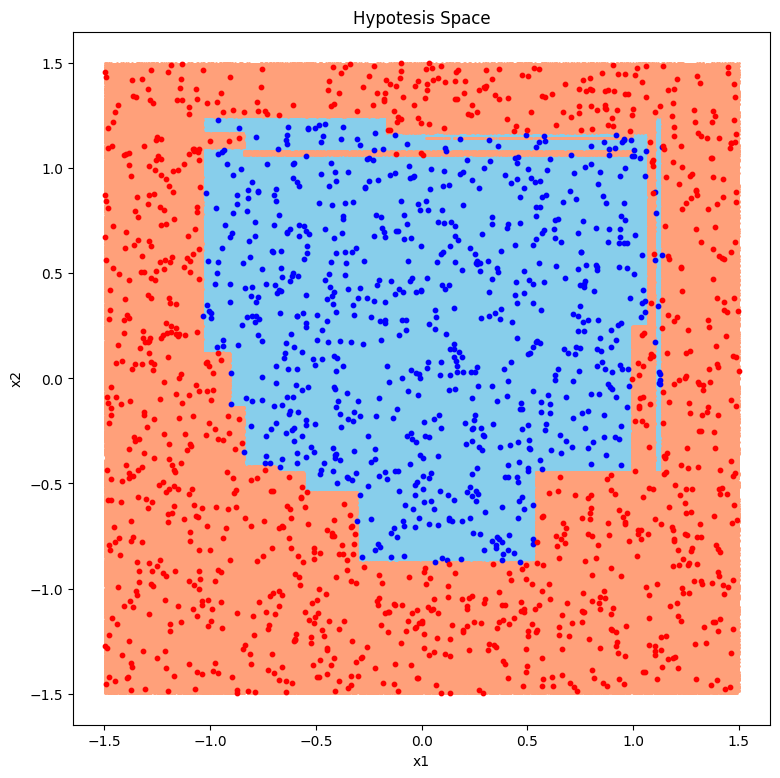

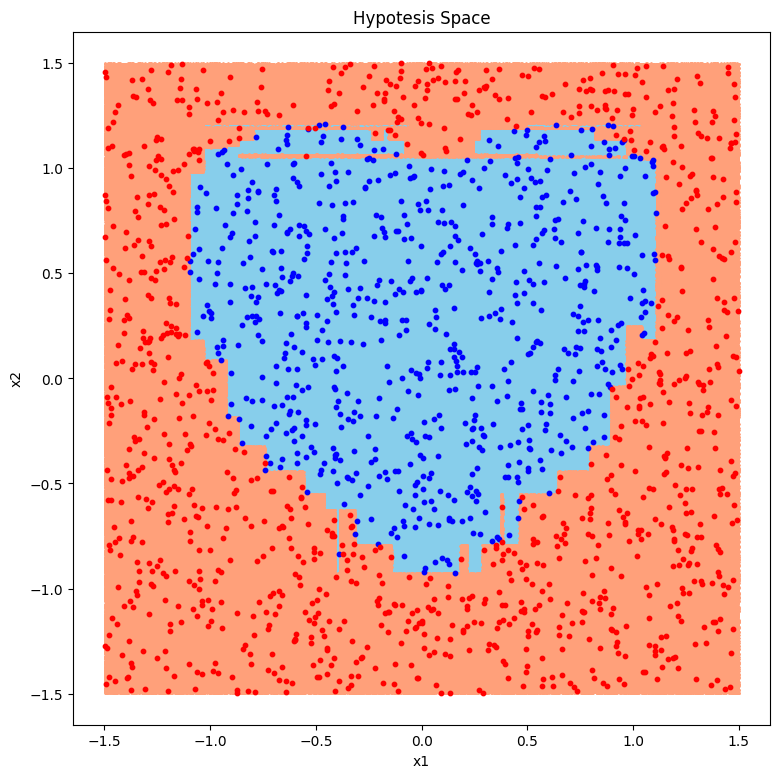

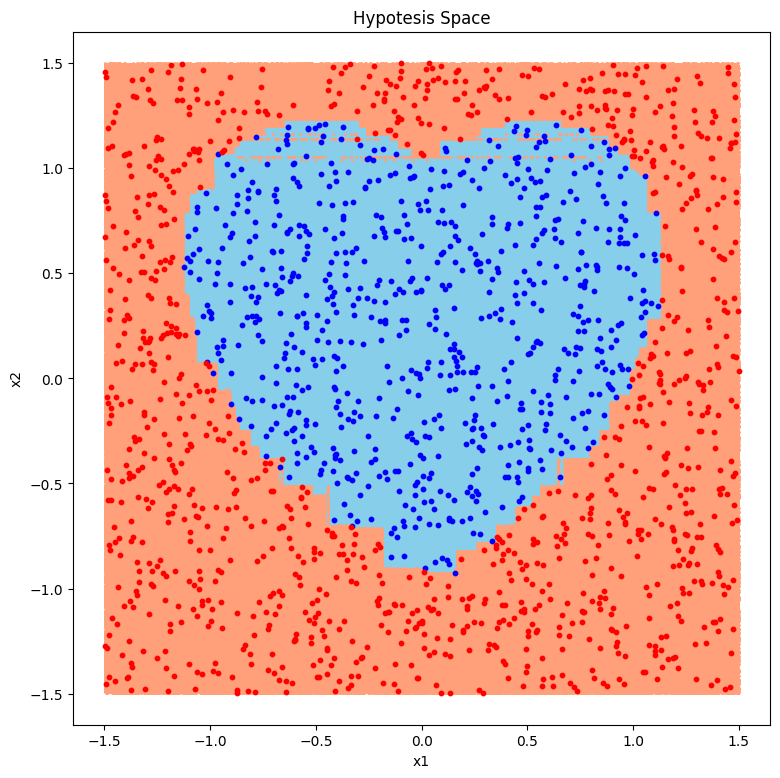

In [33]:
learning_rate = {}
info = {}
for set in ["32","128","512","2048","8192"]:
    n_nodes = 0
    training = training_data[set]
    tree = Train(training)
    g = Graph()
    CreateGraph(tree)
    df_test = Test(df_test_set,tree)

    # number of nodes
    actual_labels = list(df_actual["y"])
    predicted_labels = list(df_test["y"])
    
    # Error
    accuracy = 1 - sum(1 for a, p in zip(actual_labels, predicted_labels) if a == p) / len(actual_labels)
    learning_rate[int(set)] = accuracy
    info[set] = (n_nodes,accuracy)
        
    CreateSpace(tree,df_test,set+".png")

In [34]:
info

{'32': (7, 0.16095132743362828),
 '128': (25, 0.0752212389380531),
 '512': (57, 0.058075221238938046),
 '2048': (137, 0.03761061946902655),
 '8192': (251, 0.014933628318584025)}

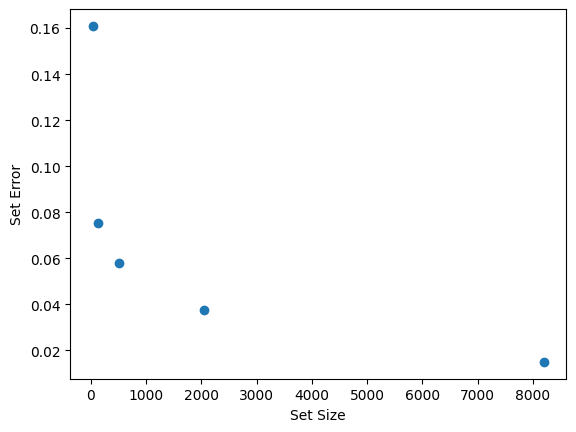

In [35]:
x = list(learning_rate.keys())
y = list(learning_rate.values())

# Create the scatter plot
plt.scatter(x, y)

# Add labels and title
plt.xlabel("Set Size")
plt.ylabel("Set Error")
#plt.title("Scatter Plot of Points")

plt.savefig("2_7a.png")
# Show the plot
plt.show()


### 3

In [37]:
learning_rate = {}
info = {}
for set in ["32","128","512","2048","8192"]:
    data = training_data[set]
    
    # Split the data into features (X) and target labels (y)
    X = data[['x1', 'x2']]
    y = data['y']
    X_t = df_test_set[['x1', 'x2']]
    y_t = df_test_set['y']
    
    # Split the data into training and testing sets
    X_train = X
    y_train = y

    X_test = X_t
    y_test = y_t
    
    # Create a Decision Tree Classifier
    clf = DecisionTreeClassifier(random_state=42)
    
    # Fit the classifier to the training data
    clf.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = clf.predict(X_test)

    # Get the number of nodes in the decision tree
    n_nodes = clf.tree_.node_count
    
    # Evaluate the classifier
    #accuracy = accuracy_score(y_test, y_pred)
    #error = 1 - accuracy
    error = 1 - sum(1 for a, p in zip(y_test, y_pred) if a == p) / len(actual_labels)

    learning_rate[int(set)] = error
    info[set] = (n_nodes,error)


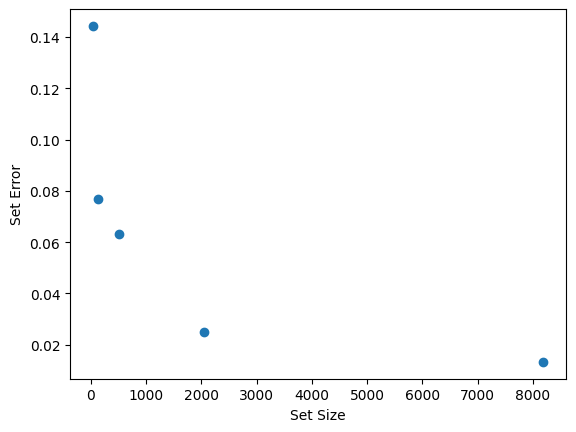

In [38]:
x = list(learning_rate.keys())
y = list(learning_rate.values())

# Create the scatter plot
plt.scatter(x, y)

# Add labels and title
plt.xlabel("Set Size")
plt.ylabel("Set Error")
#plt.title("Scatter Plot of Points")

plt.savefig("3.png")
# Show the plot
plt.show()

In [39]:
info

{'32': (7, 0.14435840707964598),
 '128': (23, 0.07688053097345138),
 '512': (57, 0.06305309734513276),
 '2048': (121, 0.02488938053097345),
 '8192': (255, 0.013274336283185861)}

### 4

In [83]:
# Generate the training set
np.random.seed(0)  # For reproducibility
a, b = 0, 10
n = 100
x_train = np.sort(np.random.uniform(a, b, n))
y_train = np.sin(x_train)

In [84]:
# Buid the model
model = lagrange(x_train, y_train)

In [85]:
# Generate test set
x_test = np.sort(np.random.uniform(a, b, 20))
y_test = np.sin(x_test)

Train error 342.9043039477804
Test error 340.479863272358


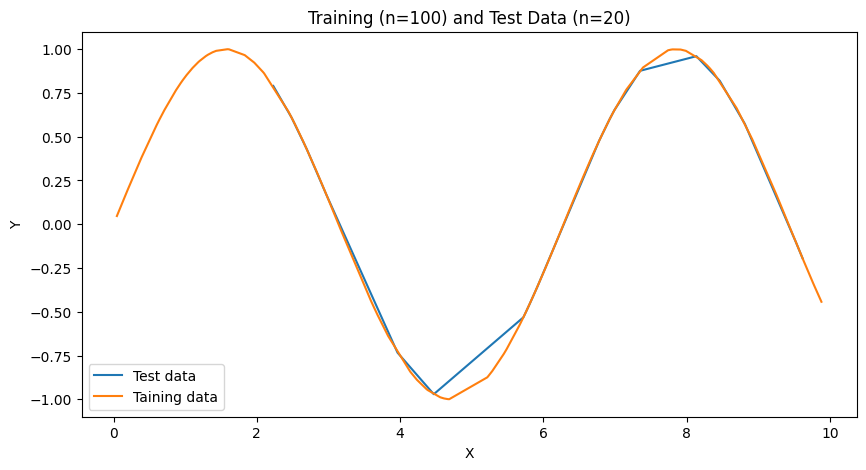

In [86]:
# Calculate train and test error
train_error = np.log(np.mean((Polynomial(model.coef[::-1])(x_train) - y_train)**2))
test_error = np.log(np.mean((Polynomial(model.coef[::-1])(x_test) - y_test)**2))
print("Train error", train_error)
print("Test error", test_error)
plt.figure(figsize=(10, 5))
plt.plot(x_test, y_test, label="Test data")
plt.plot(x_train, y_train, label="Taining data")
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Training (n=100) and Test Data (n=20)')
plt.savefig("4a.png")
plt.show()

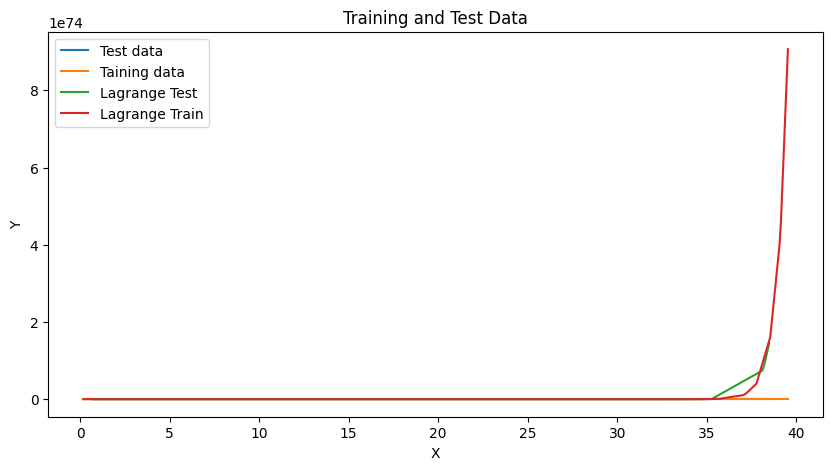

In [67]:
plt.figure(figsize=(10, 5))
plt.plot(x_test, y_test, label="Test data")
plt.plot(x_train, y_train, label="Taining data")
plt.plot(x_test, Polynomial(model.coef[::-1])(x_test), label="Lagrange Test")
plt.plot(x_train, Polynomial(model.coef[::-1])(x_train), label="Lagrange Train")
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Training and Test Data')
plt.show()

Std Deviation 0.1
Train error 346.63584305448427
Test error 340.6384043955909



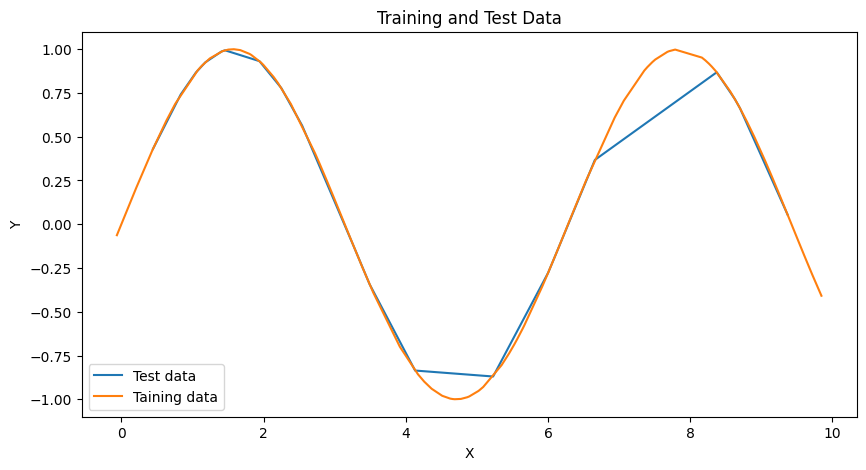

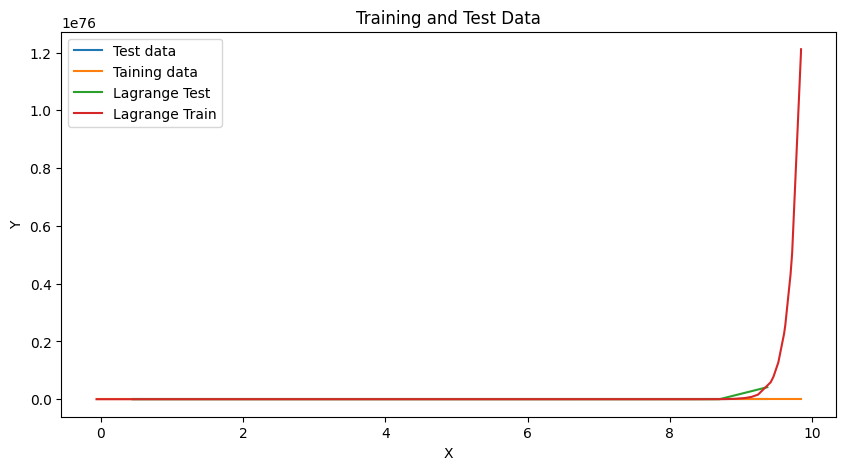

Std Deviation 0.5
Train error 341.1644677635012
Test error 342.89056536283175



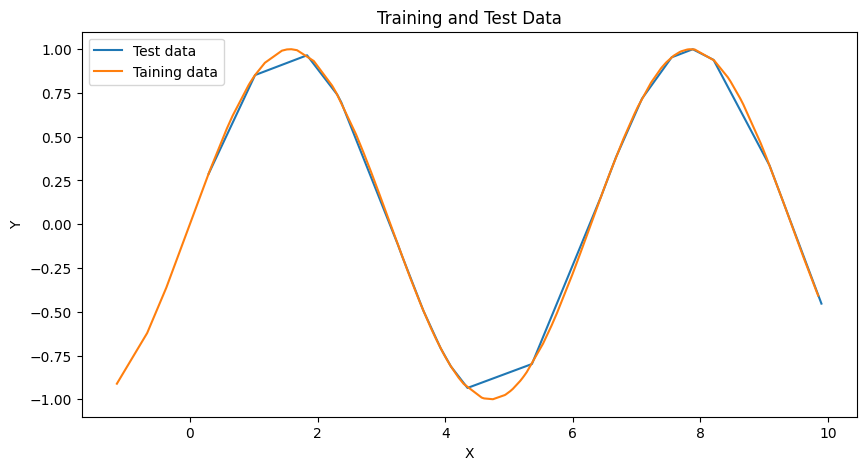

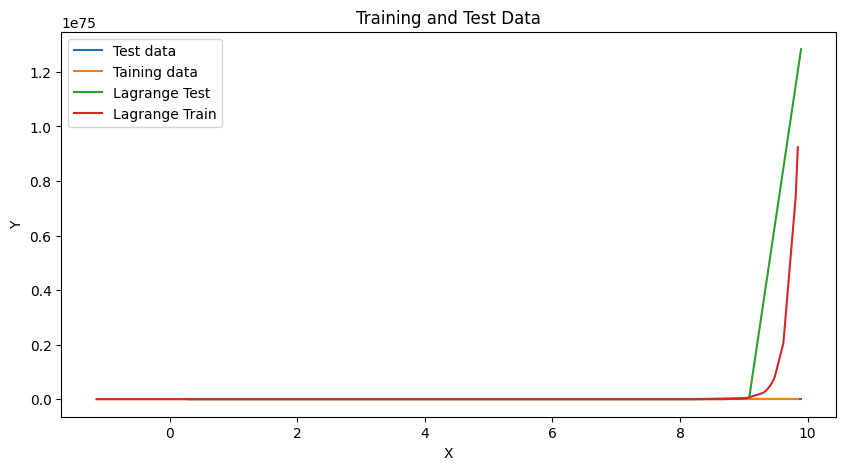

Std Deviation 1
Train error 374.6698584225636
Test error 361.8627736524263



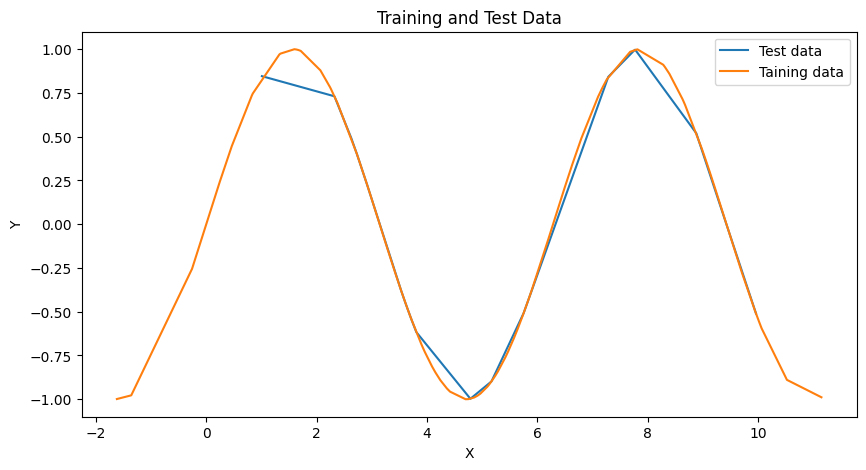

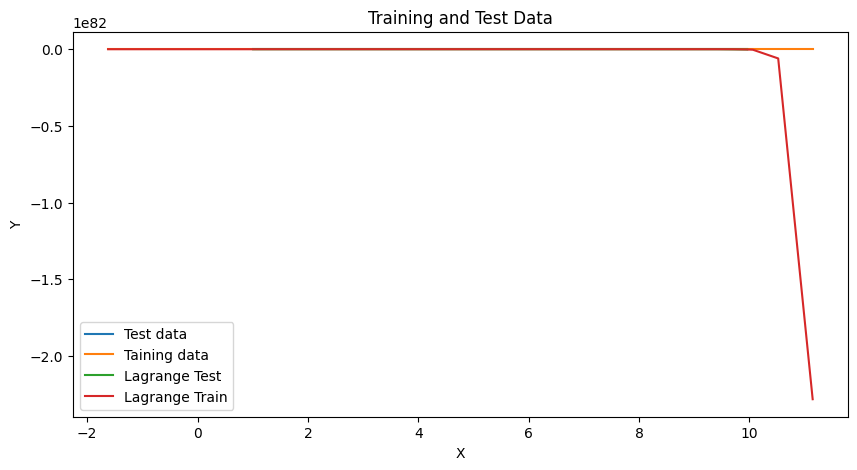

Std Deviation 10
Train error 303.42029618609916
Test error 145.7036069856375



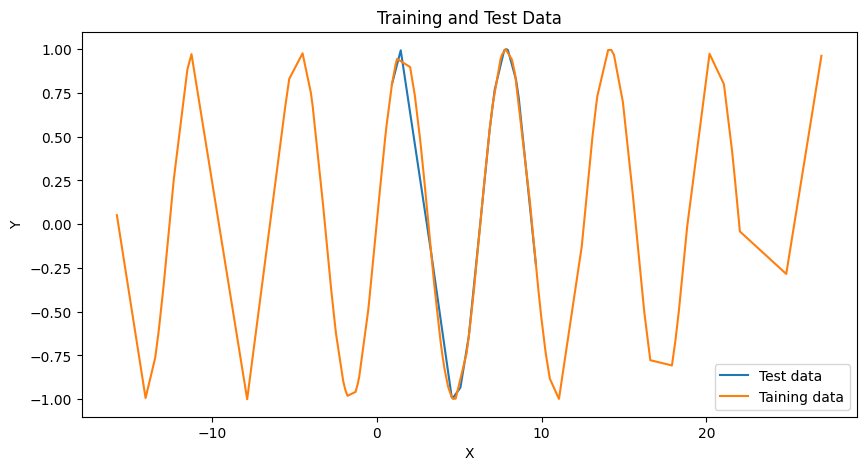

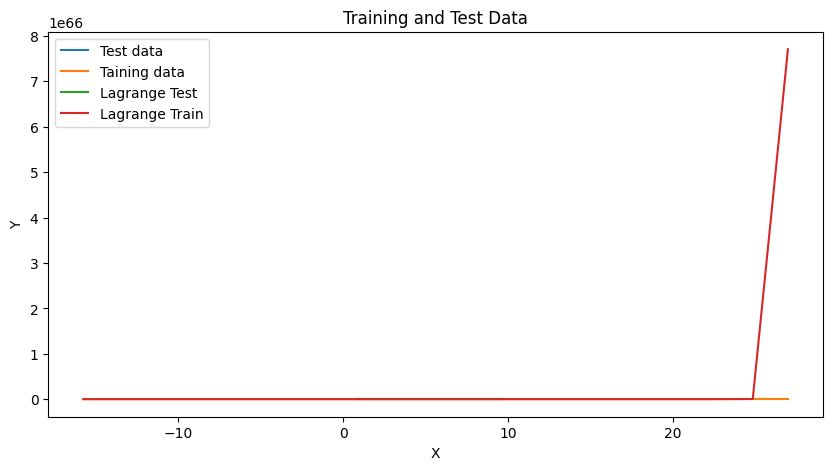

Std Deviation 20
Train error 314.7672645543699
Test error 78.24607161595897



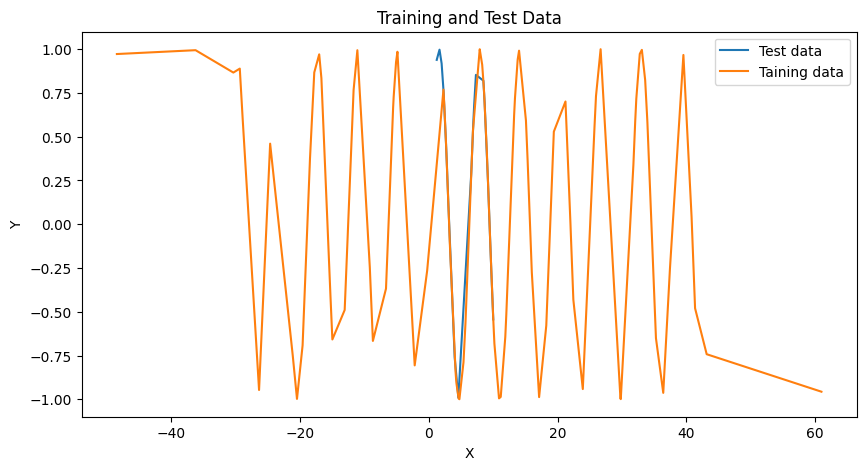

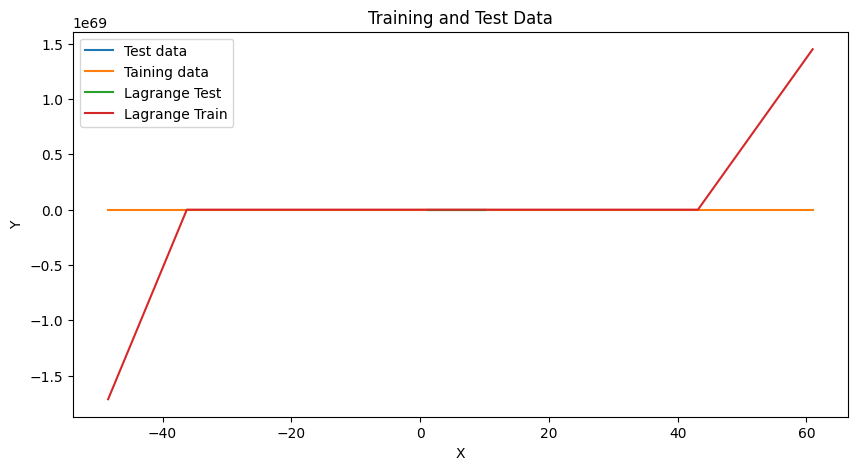

Std Deviation 40
Train error 290.50505164411
Test error -7.340093633895659



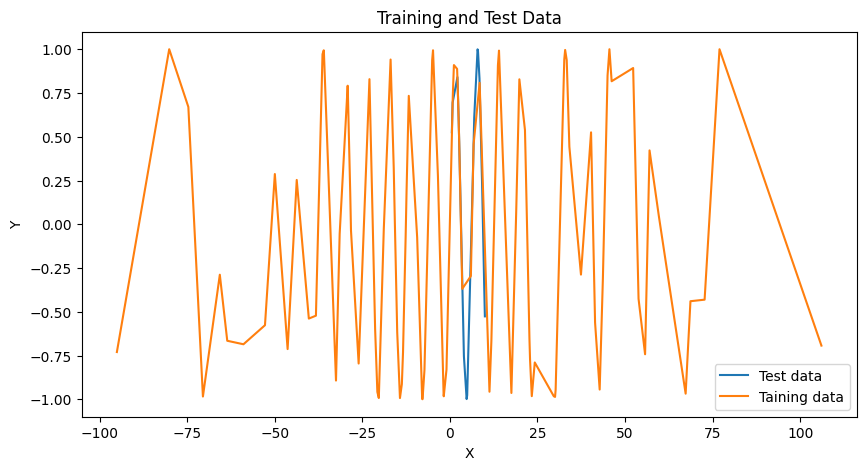

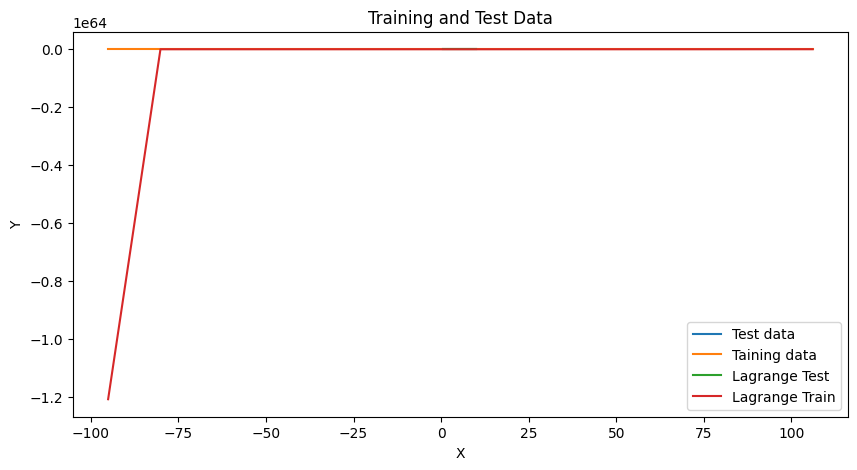

In [88]:
# Add noise

for std_deviation in [0.1,0.5,1,10,20,40]:
    gaussian_noise = np.random.normal(0, std_deviation, n)
    
    # Recalculate Data
    x_train = np.sort(np.random.uniform(a, b, n) + gaussian_noise)
    y_train = np.sin(x_train)
    # Buid the model
    model = lagrange(x_train, y_train)
    x_test = np.sort(np.random.uniform(a, b, 20))
    y_test = np.sin(x_test)
    
    train_error = np.log(np.mean((Polynomial(model.coef[::-1])(x_train) - y_train)**2))
    test_error = np.log(np.mean((Polynomial(model.coef[::-1])(x_test) - y_test)**2))
    
    print("Std Deviation", std_deviation)
    print("Train error", train_error)
    print("Test error", test_error)
    print("")
    plt.figure(figsize=(10, 5))
    plt.plot(x_test, y_test, label="Test data")
    plt.plot(x_train, y_train, label="Taining data")
    plt.legend()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Training and Test Data')
    plt.show()
    
    plt.figure(figsize=(10, 5))
    plt.plot(x_test, y_test, label="Test data")
    plt.plot(x_train, y_train, label="Taining data")
    plt.plot(x_test, Polynomial(model.coef[::-1])(x_test), label="Lagrange Test")
    plt.plot(x_train, Polynomial(model.coef[::-1])(x_train), label="Lagrange Train")
    plt.legend()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Training and Test Data')
    plt.show()